# Custom Mixing Coefficients Initialization for known Activation Function Approximation

## Considered functions : elu and tanh
## Used in a CNN
* Plot the resulting Kaf

In [1]:
# Essential Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras imports
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# Custom imports
import kafnet
from kafnet import Kaf


In [3]:
# Load Breast Cancer dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Preprocessing is taken from here:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

11493376/11490434 [==============================] - 5s 0us/step


In [4]:
kaf_net = Sequential([
    Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
    Kaf(20, conv=True, ridge='elu'),
    Conv2D(32, (3, 3)),
    Kaf(20, conv=True, ridge='elu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(100),
    Kaf(20),
    Dense(10, activation='softmax'),
])

In [5]:
kaf_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
kaf (Kaf)                    (None, 26, 26, 32)        660       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
kaf_1 (Kaf)                  (None, 24, 24, 32)        660       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               4

In [6]:
## How does the initial elu-kaf look like? (before training)

d = [v for v in kaf_net.non_trainable_variables if "kaf/dictionary" in v.name][0][0][0][0][0] # Get the dictionary from the desired kaf
a = [v for v in kaf_net.trainable_variables if "kaf/mix_coeffs" in v.name][0][0][0][0][0] # Get the mixing coefficients "" "" "" ""\

print(a)


tf.Tensor(
[   6.7753763  -33.632282    84.3531    -159.42029    251.03444
 -352.56827    451.96225   -539.0743     598.7213    -620.0498
  594.2431    -526.6319     431.65268   -319.68475    209.97343
 -106.878914    30.95321     20.824778   -31.63174     24.029533 ], shape=(20,), dtype=float32)


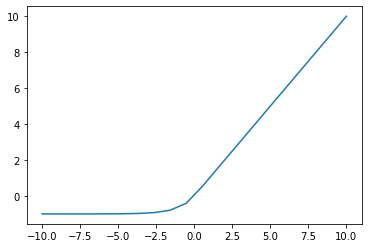

In [7]:
kaf_init = []
for d_i in d:
   kaf_init.append(kafnet.kafActivation(d_i, a, d, 1/(6*(np.power(1.0526,2))) ))#this case the step was computed for D=20

# plot the kaf over d, note how the ridge implementation appears to work
plt.plot(d, kaf_init)

In [8]:
# Set optimizer loss and metrics
from tensorflow.keras import losses, optimizers, metrics

opt = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()

kaf_net.compile(optimizer=opt, loss=loss)

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.int64)))
test_data = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.int64)))

In [10]:
# Now train the model
history = kaf_net.fit(train_data.shuffle(1000).batch(32), epochs=5)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 73s 39ms/step - loss: 0.1499
Epoch 2/5
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0359
Epoch 3/5
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0208
Epoch 4/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0142
Epoch 5/5
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0121


In [11]:
# Evaluation. Note, the accuracy has improved from the randomly initialized KAFs
acc = tf.metrics.Accuracy()
for xb, yb in test_data.batch(32):
    acc(yb, tf.argmax(kaf_net(xb), axis=1))
print('Test accuracy after epoch {} is: '+ str(acc.result()))

Test accuracy after epoch {} is: tf.Tensor(0.9864, shape=(), dtype=float32)


In [12]:
## How does the initial kaf look like after training? 

a = [v for v in kaf_net.trainable_variables if "kaf/mix_coeffs" in v.name][0][0][0][0][0] # Get the learned mixing coefficients 

print(a) #slight change from original coefficients

tf.Tensor(
[   6.773742  -33.64163    84.337906 -159.43378   251.02547  -352.57397
  451.9598   -539.07544   598.72284  -620.05005   594.24384  -526.6347
  431.6443   -319.6965    209.9576   -106.8998     30.92452    20.78543
  -31.663725   24.025072], shape=(20,), dtype=float32)


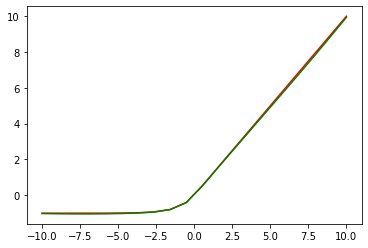

In [13]:
kaf_final = []

for d_i in d:
   kaf_final.append(kafnet.kafActivation(d_i, a, d, 1/(6*(np.power(1.0526,2))) ))

plt.plot(d, kaf_init, 'r')
plt.plot(d, kaf_final, 'g')